In [10]:
import json
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Carregar dados do arquivo JSON
with open('dados_final.json', 'r') as f:
    data = json.load(f)

In [11]:
# Definir o número máximo de satélites esperado em uma amostra
max_satellites = 20
for sample in data:
    gnss_data = sample.get('gnss_data', {})
    satellites = gnss_data.get('satellites', [])
    max_satellites = max(max_satellites, len(satellites))

In [12]:
# Extrair características e rótulos
X_data = []
y_lat = []
y_lon = []

In [13]:
for sample in data:
    gnss_data = sample.get('gnss_data', {})
    satellites = gnss_data.get('satellites', [])
    num_satellites = len(satellites)
    
    # Extrair características dos satélites
    satellite_features = []
    for i in range(max_satellites):
        if i < num_satellites:
            satellite = satellites[i]
            satellite_features.extend([
                satellite.get('svid', 0),
                satellite.get('constellationType', 0),
                satellite.get('azimuthDegrees', 0),
                satellite.get('elevationDegrees', 0),
                satellite.get('cn0DbHz', 0),
                satellite.get('basebandCn0DbHz', 0),
                satellite.get('carrierFrequencyHz', 0)
            ])
        else:
            # Preencher com valores padrão se não houver dados para o satélite
            satellite_features.extend([0] * 7)
    
    # Extrair características restantes
    altitude = gnss_data.get('altitude', 0)
    accuracy = gnss_data.get('accuracy', 0)
    speed = gnss_data.get('speed', 0)
    
    # Concatenar todas as características
    features = [altitude, accuracy, speed]
    features.extend(satellite_features)
    
    # Adicionar à lista de características
    X_data.append(features)
    
    # Adicionar rótulos
    y_lat.append(gnss_data.get('latitudeDiferenca', 0))
    y_lon.append(gnss_data.get('longitudeDiferenca', 0))



Epoch 1/100
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 5s 929us/step - loss: 150851616243712.0000 - val_loss: 778553786368.0000
Epoch 2/100
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 4s 917us/step - loss: 1235225542656.0000 - val_loss: 24733421568.0000
Epoch 3/100
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 5s 924us/step - loss: 146451595264.0000 - val_loss: 18831308800.0000
Epoch 4/100
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 3756715776.0000 - val_loss: 0.0165
Epoch 5/100
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0153 - val_loss: 0.0084
Epoch 6/100
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0051 - val_loss: 1.1383e-05
Epoch 7/100
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2.1215e-06 - val_loss: 2.4086e-09
Epoch 8/100
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 5s 969us/step - loss: 2.3291e-09 - val_loss: 2.4151e-09
Epoch 9/100
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2.3779e-09 - val_loss: 2.4219e-09
Epoch 10/100
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 5s 982us/step - loss: 2.4098e-09 - val_los

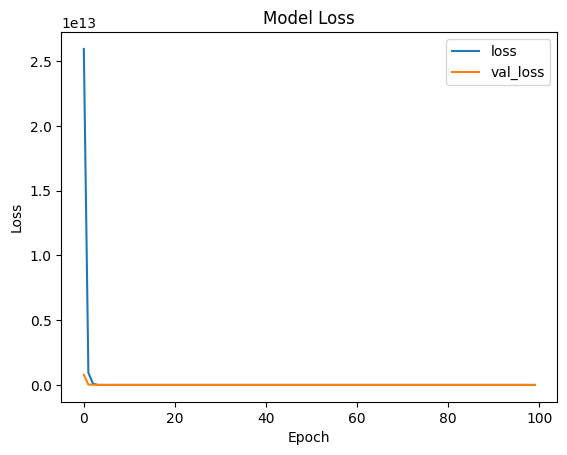

In [18]:
# Converter para arrays numpy
X = np.array(X_data)
y_lat = np.array(y_lat)
y_lon = np.array(y_lon)

# Dividir dados em conjuntos de treinamento e teste
X_train, X_test, y_lat_train, y_lat_test, y_lon_train, y_lon_test = train_test_split(X, y_lat, y_lon, test_size=0.26, random_state=42)

# Definir arquitetura da RNA
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
history = model.fit(X_train, y_lat_train, epochs=100, batch_size=32, validation_data=(X_test, y_lat_test))

# Avaliar o modelo
loss = model.evaluate(X_test, y_lat_test)
print(f'Loss: {loss}')

# Fazer previsões
predictions = model.predict(X_test)

# Calcular métricas de desempenho
mae = mean_absolute_error(y_lat_test, predictions)
print("Mean Absolute Error:", mae)

# Exibir exemplos de previsões e diferenças
num_examples = 10
for i in range(num_examples):
    print("Exemplo", i+1)
    print("Previsão:", predictions[i][0])
    print("Valor Real:", y_lat_test[i])
    print("Diferença:", predictions[i][0] - y_lat_test[i])
    print()

# Plotar gráfico de perda ao longo das épocas
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Salvar o modelo
model.save('model_lat.h5')


Epoch 1/100


c:\Users\bruno\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5118/5118 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 5617208411553792.0000 - val_loss: 4287621496832.0000
Epoch 2/100
5118/5118 ━━━━━━━━━━━━━━━━━━━━ 5s 896us/step - loss: 3957460828160.0000 - val_loss: 212848590848.0000
Epoch 3/100
5118/5118 ━━━━━━━━━━━━━━━━━━━━ 5s 960us/step - loss: 991217123328.0000 - val_loss: 7903208960.0000
Epoch 4/100
5118/5118 ━━━━━━━━━━━━━━━━━━━━ 5s 966us/step - loss: 926676221952.0000 - val_loss: 27523151872.0000
Epoch 5/100
5118/5118 ━━━━━━━━━━━━━━━━━━━━ 5s 899us/step - loss: 110150615040.0000 - val_loss: 31809851392.0000
Epoch 6/100
5118/5118 ━━━━━━━━━━━━━━━━━━━━ 5s 898us/step - loss: 114678464512.0000 - val_loss: 60863291392.0000
Epoch 7/100
5118/5118 ━━━━━━━━━━━━━━━━━━━━ 5s 979us/step - loss: 25314291712.0000 - val_loss: 1348122752.0000
Epoch 8/100
5118/5118 ━━━━━━━━━━━━━━━━━━━━ 5s 959us/step - loss: 175374663680.0000 - val_loss: 181206176.0000
Epoch 9/100
5118/5118 ━━━━━━━━━━━━━━━━━━━━ 5s 908us/step - loss: 9336159232.0000 - val_loss: 0.0034
Epoch 10/100
51

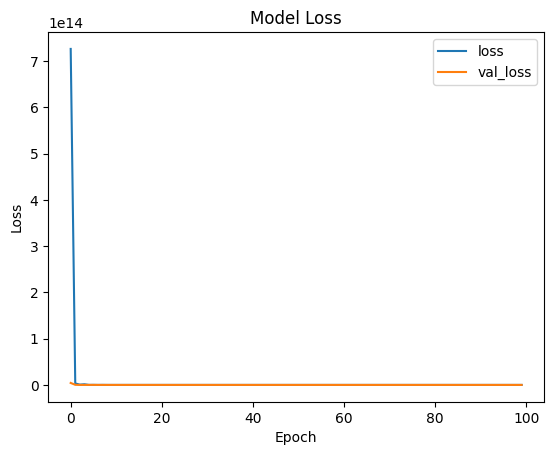

In [19]:
import json
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Carregar dados do arquivo JSON
with open('dados_final.json', 'r') as f:
    data = json.load(f)

# Definir o número máximo de satélites esperado em uma amostra
max_satellites = 0
for sample in data:
    gnss_data = sample.get('gnss_data', {})
    satellites = gnss_data.get('satellites', [])
    max_satellites = max(max_satellites, len(satellites))

# Extrair características e rótulos
X_data = []
y_lat = []
y_lon = []

for sample in data:
    gnss_data = sample.get('gnss_data', {})
    satellites = gnss_data.get('satellites', [])
    num_satellites = len(satellites)
    
    # Extrair características dos satélites
    satellite_features = []
    for i in range(max_satellites):
        if i < num_satellites:
            satellite = satellites[i]
            satellite_features.extend([
                satellite.get('svid', 0),
                satellite.get('constellationType', 0),
                satellite.get('azimuthDegrees', 0),
                satellite.get('elevationDegrees', 0),
                satellite.get('cn0DbHz', 0),
                satellite.get('basebandCn0DbHz', 0),
                satellite.get('carrierFrequencyHz', 0)
            ])
        else:
            # Preencher com valores padrão se não houver dados para o satélite
            satellite_features.extend([0] * 7)
    
    # Extrair características restantes
    altitude = gnss_data.get('altitude', 0)
    accuracy = gnss_data.get('accuracy', 0)
    speed = gnss_data.get('speed', 0)
    
    # Concatenar todas as características
    features = [altitude, accuracy, speed]
    features.extend(satellite_features)
    
    # Adicionar à lista de características
    X_data.append(features)
    
    # Adicionar rótulos
    y_lat.append(gnss_data.get('latitudeDiferenca', 0))
    y_lon.append(gnss_data.get('longitudeDiferenca', 0))

# Converter para arrays numpy
X = np.array(X_data)
y_lat = np.array(y_lat)
y_lon = np.array(y_lon)

# Dividir dados em conjuntos de treinamento e teste
X_train, X_test, y_lat_train, y_lat_test, y_lon_train, y_lon_test = train_test_split(X, y_lat, y_lon, test_size=0.22, random_state=42)

# Definir arquitetura da RNA
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
history = model.fit(X_train, y_lat_train, epochs=100, batch_size=32, validation_data=(X_test, y_lat_test))

# Avaliar o modelo
loss = model.evaluate(X_test, y_lat_test)
print(f'Loss: {loss}')

# Fazer previsões
predictions = model.predict(X_test)

# Calcular métricas de desempenho
mae = mean_absolute_error(y_lat_test, predictions)
print("Mean Absolute Error:", mae)

# Exibir exemplos de previsões e diferenças
num_examples = 10
for i in range(num_examples):
    print("Exemplo", i+1)
    print("Previsão:", predictions[i][0])
    print("Valor Real:", y_lat_test[i])
    print("Diferença:", predictions[i][0] - y_lat_test[i])
    print()

# Plotar gráfico de perda ao longo das épocas
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Salvar o modelo
model.save('model_lat.h5')
